<h1><center>Quick and Effective EDA H&M</center></h1>


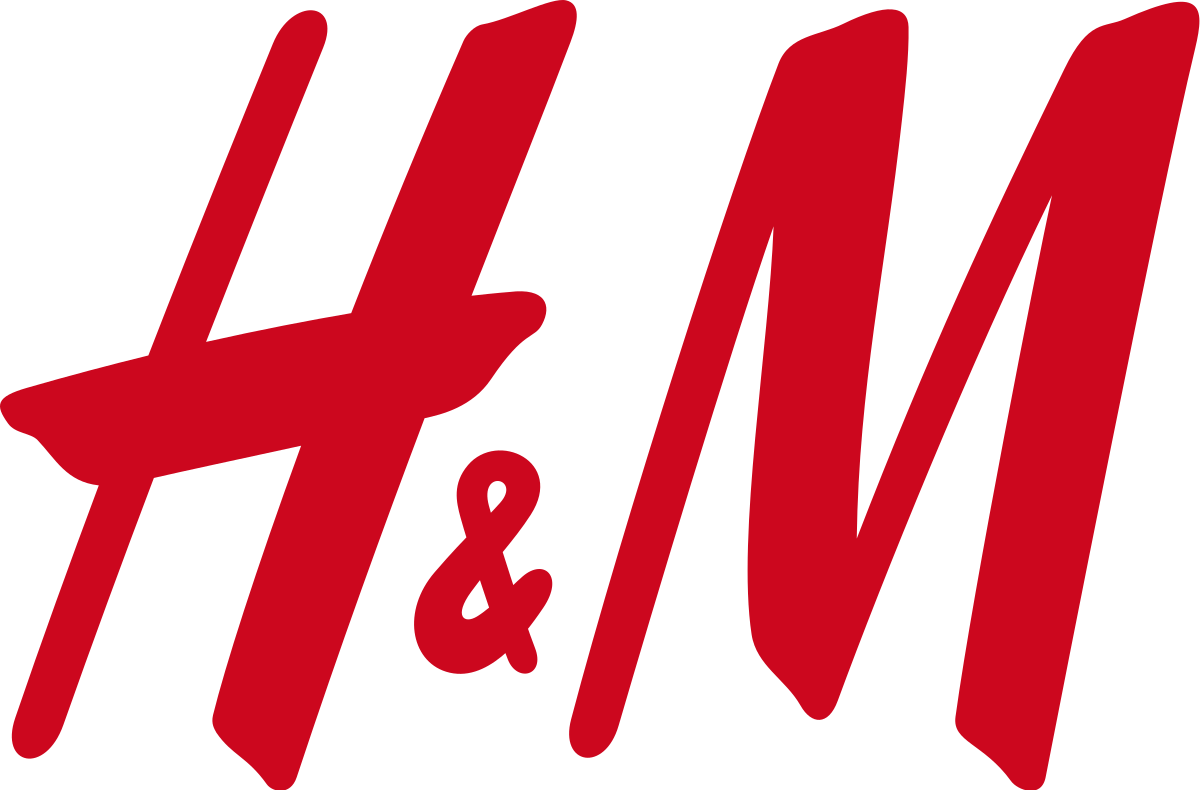

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    
   Data files:
<ul>
    <li> Images: Each image file represents the article and has the name of the article ID.
    <li> articles.csv : csv file containing informations about type, color, description of the article.
    <li> customeres.csv: csv file containing informations about customer and his history.
    <li> transactions_train.csv: csv file containing all the transactions of all the customers.
<p style="padding: 10px;
              color:white;">
</p>
</div>

In [ ]:
import pandas as pd
import datatable as dt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
sns.set_theme()
sns.set_context("paper")

In [ ]:
class Paths:
    image_dir = '../input/h-and-m-personalized-fashion-recommendations/images'
    article_csv = '../input/h-and-m-personalized-fashion-recommendations/articles.csv'
    customer_csv = '../input/h-and-m-personalized-fashion-recommendations/customers.csv'
    tx_csv = '../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv'
    sub_csv = '../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv'

In [ ]:
customer_df = pd.read_csv( Paths.customer_csv,)  # dtype=customer_dtype
article_df = pd.read_csv( Paths.article_csv)
customer_df.head()

In [ ]:
article_df.head()

In [ ]:
%%time
transactions_df = dt.fread( Paths.tx_csv )
transactions_df = transactions_df.to_pandas()
transactions_df.head()

# Customer data exploration:

## 1.1 What features we expect?

In [ ]:
print(f'Number of Customers = {len(customer_df)}')
for c in customer_df.columns:
    print(f'Feature: {c} ... # Unique values = {len(customer_df[c].unique())}... Number of Nans = {customer_df[c].isna().sum()}')

# 1.2 Plot Features distributions:

### 1.2.1. Replace Nan values in FN with zero because all the values of FN are equal to 1 or Nan.

In [ ]:
print(f'unique values of FN = {customer_df.FN.unique()}')
customer_df.FN.fillna(value = 0, inplace=True)

In [ ]:
ax = sns.countplot(x="FN", data=customer_df)

### 1.2.2 Replace Nan values in Active with zero because all the values of FN are equal to 1 or Nan.

In [ ]:
print(f'unique values of FN = {customer_df.Active.unique()}')
customer_df.Active.fillna(value = 0, inplace=True)

In [ ]:
ax = sns.countplot(x="Active", data=customer_df)

### FN and Active are quite correlated:

In [ ]:
confusion_m = confusion_matrix(customer_df.FN,customer_df.Active)
sns.heatmap(confusion_m)

### 1.2.3 Fashion news and club status:

In [ ]:
print(f'unique values of fashion news = {customer_df.fashion_news_frequency.unique()}')
print(f'unique values of club member status = {customer_df.club_member_status.unique()}')

### NONE and None seriously ?! (Keep only one)

In [ ]:
replace = {"fashion_news_frequency":{"None":"NONE"}}
customer_df = customer_df.replace(replace)

In [ ]:
ax = sns.countplot(x="club_member_status", data=customer_df)

In [ ]:
ax = sns.countplot(x="fashion_news_frequency", data=customer_df)

In [ ]:
customer_df_cp = customer_df.copy()
replace = {'fashion_news_frequency':{"NONE":2, "Regularly":0, "Monthly":1, None:3},
            'club_member_status': {"ACTIVE":0 , "PRE-CREATE":1, "LEFT CLUB":2, None:3}}

customer_df_cp.replace(replace, inplace=True)

confusion_m = confusion_matrix(customer_df_cp.fashion_news_frequency,customer_df_cp.club_member_status)
sns.heatmap(confusion_m, xticklabels=["ACTIVE","PRE-CREATE","LEFT CLUB", "nan"], yticklabels=["Regular","Monthly","NONE",'nan'])

In [ ]:
customer_df.groupby(['club_member_status','fashion_news_frequency']).count()

### 1.2.4 Distribution of Age:

In [ ]:
sns.distplot(customer_df['age'])

### 1.2.5 Zip code unique values:

In [ ]:
customer_df.groupby('postal_code').count()

# Articles Exploration:

In [ ]:
print(f'Number of Articles = {len(article_df)}')
for c in article_df.columns:
    print(f'Feature: {c} ... # Unique values = {len(article_df[c].unique())}... Number of Nans = {article_df[c].isna().sum()}')

In [ ]:
fig,ax = plt.subplots(1,4, figsize=(20,7))
fig.autofmt_xdate(rotation=90)
sns.countplot(x="product_group_name", data=article_df,ax=ax[0])
sns.countplot(x="graphical_appearance_name", data=article_df, ax=ax[1])
sns.countplot(x="product_group_name", data=article_df, ax=ax[2])
sns.countplot(x="index_name", data=article_df, ax=ax[3])


In [ ]:
fig,ax = plt.subplots(1,3, figsize=(20,7))
fig.autofmt_xdate(rotation=90)
sns.countplot(x="garment_group_name", data=article_df,ax=ax[0])
sns.countplot(x="perceived_colour_value_name", data=article_df, ax=ax[1])
sns.countplot(x="perceived_colour_master_name", data=article_df, ax=ax[2])

# Transaction EDA:

In [ ]:
print(f'Number of Transactions = {len(transactions_df)}')
for c in transactions_df.columns:
    print(f'Feature: {c} ... # Unique values = {len(transactions_df[c].unique())}... Number of Nans = {transactions_df[c].isna().sum()}')

## Sales Per Time:

In [ ]:
df = transactions_df.groupby('t_dat')['price'].agg(['mean']).sort_values(by = 't_dat', ascending=False).reset_index()

In [ ]:
plt.figure(figsize=(20,5))
df.plot.bar(x='t_dat', y='mean', title='Total Sales daily', color='r')
plt.xticks([])

## Top customer by number of purchases and by total price:

In [ ]:
transactions_df.groupby('customer_id').count().sort_values(by = 'price', ascending=False).index[:10]

In [ ]:
transactions_df.groupby('customer_id').sum().sort_values(by = 'price', ascending=False).index[:10]

# Displaying some Images:

In [ ]:
def join_image_article(img):
    
        articel_id = img[:-4]
        article_desc = article_df[article_df['article_id']== int(articel_id)].loc[:,'detail_desc'].values[0]
        desc_list = article_desc.split(' ')
        for j, elem in enumerate(desc_list):
            if j > 0 and j % 5 == 0:
                desc_list[j] = desc_list[j] + '\n'
        desc = ' '.join(desc_list)
        
        return desc

In [ ]:
def display_im(n = '011'):
    
    files = os.listdir(Paths.image_dir+'/'+n)
    numb = 5
    if len(files)<5:
        numb = len(files)
    fig, ax = plt.subplots(1,numb,  figsize=(20,30))
    
    for i in range(numb):
        
        ax[i].imshow(plt.imread(Paths.image_dir+'/'+n+'/'+files[i]))
        ax[i].set_title(join_image_article(files[i]))
         

In [ ]:
display_im('012')

In [ ]:
display_im('011')

# Test Set:

In [ ]:
submission = pd.read_csv(Paths.sub_csv)
submission.head()

In [ ]:
df3 = submission[customer_df['customer_id'].isin(submission['customer_id'])]
print(f'Percentage of train customer IDs in Test = {100*len(df3)/len(submission)}%')

# I hope this notebook was helpful to you all 🙌🏻 🙌🏻 